In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv(r"C:\Users\dharu\OneDrive\Desktop\Data Science Bootcamp\finance_economics_dataset.csv")
t = pd.to_datetime(df['Date'], errors='coerce')  
target_col = 'Close Price'

In [3]:
def ellipse_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    inside = 1 - ((x - mu_x)**2 / (sx**2 + 1e-12))
    inside = np.clip(inside, 0, None)
    return mu_y + sy * np.sqrt(inside)

def parabola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    return mu_y + (sy**2 / (sx**2 + 1e-12)) * (x - mu_x)**2

def hyperbola_wave(x, y):
    mu_x, sx = x.mean(), x.std()
    mu_y, sy = y.mean(), y.std()
    outside = (x - mu_x)**2 / (sx**2 + 1e-12) - 1
    wave = np.full_like(x, np.nan, dtype=float)
    mask = outside >= 0
    wave[mask] = mu_y + sy * np.sqrt(outside[mask])
    wave = pd.Series(wave).interpolate(limit_direction='both').values
    return wave

def choose_waveform(x, y):
    r = abs(np.corrcoef(x, y)[0,1])
    if r > 0.1:
        return ellipse_wave(x, y)
    elif r < 0.1:
        return parabola_wave(x, y)
    else:
        return hyperbola_wave(x, y)

In [4]:
def waveform_superposition(df, target=target_col):
    y = df[target].values
    features = [col for col in df.columns if col != target and df[col].dtype in [np.float64, np.int64]]
    
    W = []
    weights = []
    
    for col in features:
        x = df[col].values
        r = abs(np.corrcoef(x, y)[0,1])
        if np.isnan(r):
            continue
        weights.append(r)
        W.append(choose_waveform(x, y))
    
    weights = np.array(weights)
    weights /= weights.sum()
    W = np.array(W)
    
    y_super = np.sum(weights[:, None] * W, axis=0)
    return y_super

In [5]:
y_actual = df[target_col].values
y_wave_pred = waveform_superposition(df, target=target_col)

In [7]:
features = [col for col in df.columns if col != target_col and df[col].dtype in [np.float64, np.int64]]
X_base = df[features].values
X_wave = np.column_stack([X_base, y_wave_pred])

In [10]:
models_before = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
}

models_after = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
}

In [11]:
results_before = {}
results_after = {}

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return rmse, mae, r2

for name, model in models_before.items():
    model.fit(X_base, y_actual)
    results_before[name] = evaluate_model(model, X_base, y_actual)

for name, model in models_after.items():
    model.fit(X_wave, y_actual)
    results_after[name] = evaluate_model(model, X_wave, y_actual)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 21
[LightGBM] [Info] Start training from score 2981.249172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 22
[LightGBM] [Info] Start training from score 2981.249172


In [ ]:

header = f"{'Model':<20} {'RMSE Before':>12} {'RMSE After':>12} {'MAE Before':>12} {'MAE After':>12} {'R2 Before':>12} {'R2 After':>12}"
print(header)
print("-" * len(header))
for name in results_before.keys():  
    rmse_b, mae_b, r2_b = results_before[name]
    rmse_a, mae_a, r2_a = results_after[name]
    print(f"{name:<20} {rmse_b:12.4f} {rmse_a:12.4f} {mae_b:12.4f} {mae_a:12.4f} {r2_b:12.4f} {r2_a:12.4f}")


Model                 RMSE Before   RMSE After   MAE Before    MAE After    R2 Before     R2 After
--------------------------------------------------------------------------------------------------
Linear Regression         16.6505      16.6490      13.5496      13.5492       0.9998       0.9998
Random Forest              7.4043       7.4016       5.9834       5.9822       1.0000       1.0000
AdaBoost                  45.3994      50.8705      35.7406      40.1786       0.9984       0.9980
LightGBM                   6.3794       6.2217       5.0282       4.9407       1.0000       1.0000
XGBoost                    1.4418       1.5296       1.0051       1.0725       1.0000       1.0000


In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
models_list = list(results_before.keys())
rmse_before = [results_before[m][0] for m in models_list]
rmse_after = [results_after[m][0] for m in models_list]

In [ ]:
x = np.arange(len(models_list))  
width = 0.35

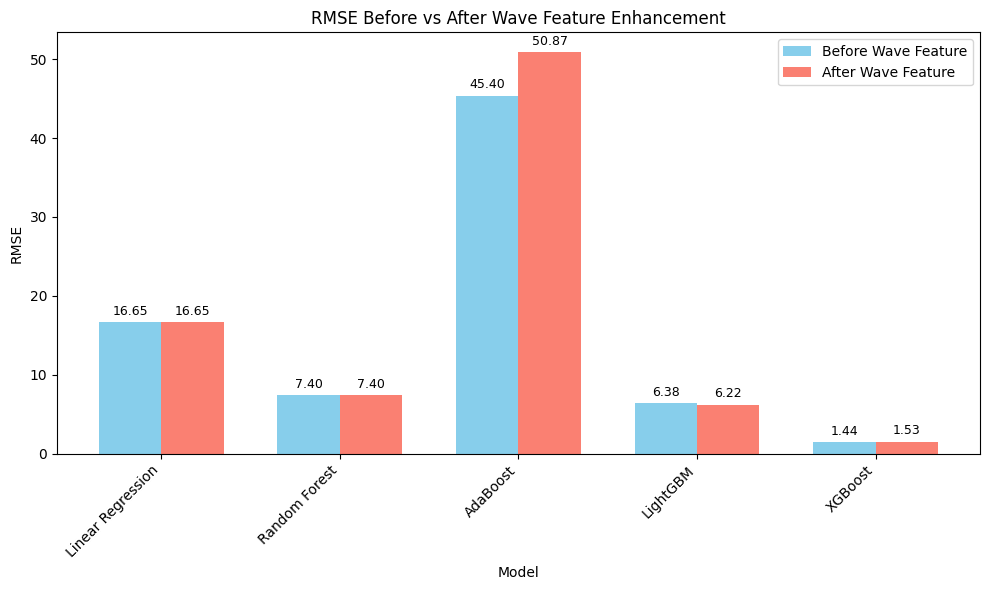

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, rmse_before, width, label='Before Wave Feature', color='skyblue')
bars2 = ax.bar(x + width/2, rmse_after, width, label='After Wave Feature', color='salmon')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Before vs After Wave Feature Enhancement')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()